In [5]:
import os
import re
import pickle
import spacy
import requests
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [6]:
pickle_file_path = os.path.join('..', 'data', 'NER_data_2.pickle')

with open(pickle_file_path, "rb") as pickle_file:
    data_NER = pickle.load(pickle_file)
len(data_NER)

4497

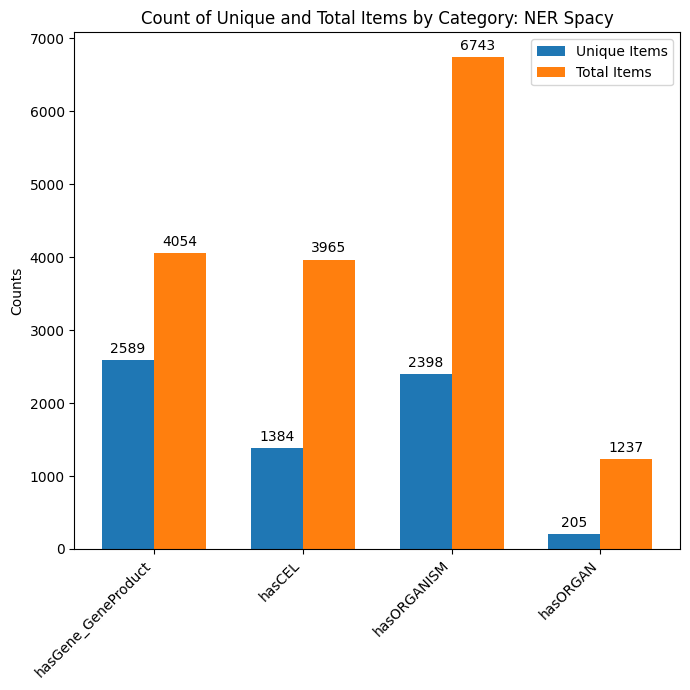

In [20]:
def plot_category_counts(unique_counts, total_counts, title):
    categories = list(unique_counts.keys())
    unique_values = list(unique_counts.values())
    total_values = list(total_counts.values())

    x = range(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 7))

    unique_bars = ax.bar(x, unique_values, width, label='Unique Items')
    total_bars = ax.bar([i + width for i in x], total_values, width, label='Total Items')

    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(categories)
    ax.legend()

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(unique_bars)
    autolabel(total_bars)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Initialize sets for each key
unique_gene_products = set()
unique_cels = set()
unique_organisms = set()
unique_organs = set()

# Iterate through the list of dictionaries
for item in data_NER:
    unique_gene_products.update(item.get('hasGene_GeneProduct', set()))
    unique_cels.update(item.get('hasCEL', set()))
    unique_organisms.update(item.get('hasORGANISM', set()))
    unique_organs.update(item.get('hasORGAN', set()))

total_gene_products = sum(len(item.get('hasGene_GeneProduct', set())) for item in data_NER)
total_cels = sum(len(item.get('hasCEL', set())) for item in data_NER)
total_organisms = sum(len(item.get('hasORGANISM', set())) for item in data_NER)
total_organs = sum(len(item.get('hasORGAN', set())) for item in data_NER)


unique_counts = {
    'hasGene_GeneProduct': len(unique_gene_products),
    'hasCEL': len(unique_cels),
    'hasORGANISM': len(unique_organisms),
    'hasORGAN': len(unique_organs)
}

total_counts = {
    'hasGene_GeneProduct': total_gene_products,
    'hasCEL': total_cels,
    'hasORGANISM': total_organisms,
    'hasORGAN': total_organs
}

# Aufrufen der Funktion, um das Balkendiagramm zu erstellen
plot_category_counts(unique_counts, total_counts, title='Count of Unique and Total Items by Category: NER Spacy')


In [7]:
data_NER[1]

{'ID': 'https://openalex.org/W2038124483',
 'hasGene_GeneProduct': set(),
 'hasCEL': {'cell'},
 'hasORGANISM': set(),
 'hasORGAN': set()}

In [4]:
import requests
import re

def extract_mesh_term(translation_set):
    mesh_term_match = re.search(r'"([^"]+)"\[MeSH Terms\]', translation_set)
    if mesh_term_match:
        return mesh_term_match.group(1)
    else:
        return None

def clean_ner_data_by_mesh(term):
    base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
    db = 'pubmed'
    retmax = 10
    
    url = f"{base_url}esearch.fcgi?db={db}&term={term}&retmax={retmax}&retmode=json"
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            data = response.json()
            translation_set = data['esearchresult']['translationset'][0]['to']
            mesh_term = extract_mesh_term(translation_set)
            return mesh_term
        except (IndexError, KeyError, ValueError, requests.RequestException) as e:
            return None
    else:
        print('Error in the request:', response.status_code)
        return None


    
#term = 'staphylococcus aureus'
term = 'california'
result = clean_ner_data_by_mesh(term)
result

'california'

In [6]:
# Beispiel Dictionarys
data_NER_test = data_NER[2500:]

for item in tqdm(data_NER_test):
    for key, value in item.items():

        if isinstance(value, set):
            mesh_set = set()
            for term in value:
                mesh_term = clean_ner_data_by_mesh(term)
                if mesh_term:
                    mesh_set.add(mesh_term)

            item[key] = mesh_set

#print(data_NER_test)
pickle_file_path = os.path.join('..', 'data', 'NER_data_2_enriched_2_part2.pickle')
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_NER_test, pickle_file)

print(f"The results list has been saved in the file '{pickle_file_path}'")


100%|██████████| 1997/1997 [1:21:09<00:00,  2.44s/it]  

Die Ergebnisliste wurde in der Datei '../data/NER_data_2_enriched_2_part2.pickle' gespeichert.


In [7]:
pickle_file_path = os.path.join('..', 'data', 'NER_data_2_enriched_2_part2.pickle')

with open(pickle_file_path, "rb") as pickle_file:
    data_NER_aufruf = pickle.load(pickle_file)

print(len(data_NER_aufruf))

1997


In [1]:
import os
import pickle


pickle_directory = os.path.join('..', 'data')
pickle_files = ['NER_data_2_enriched_2.pickle', 'NER_data_2_enriched_2_part2.pickle']

combined_data = []

for file_name in pickle_files:
    file_path = os.path.join(pickle_directory, file_name)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        combined_data.extend(data)


output_file = os.path.join(pickle_directory, 'NER_data_MESH.pickle')
with open(output_file, 'wb') as f:
    pickle.dump(combined_data, f)

print(f"The combined data was stored in {output_file}.")


The combined data was stored in ../data/NER_data_MESH.pickle.


In [18]:
pickle_file_path = os.path.join('..', 'data', 'NER_data_MESH.pickle')

with open(pickle_file_path, "rb") as pickle_file:
    data_NER_aufruf = pickle.load(pickle_file)

print(len(data_NER_aufruf))

4497


#### Comparison of frequency of extracted entities before and after MASH enrichment

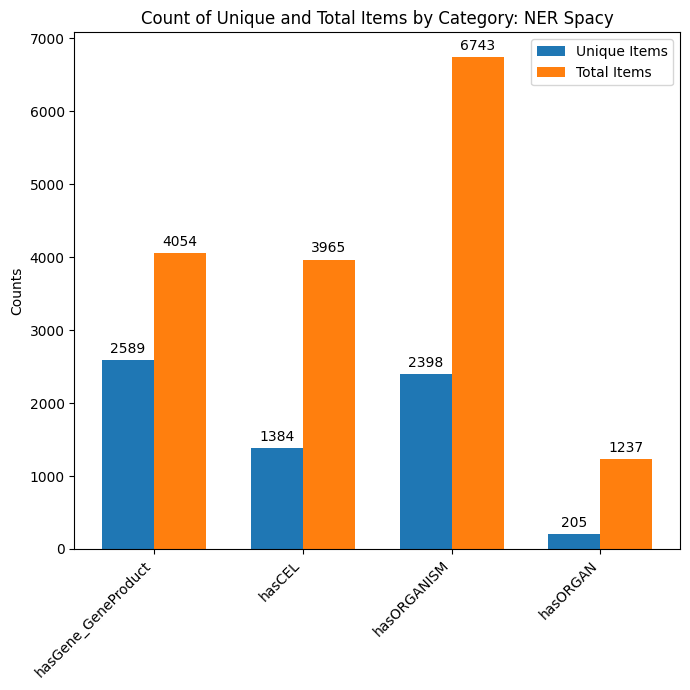

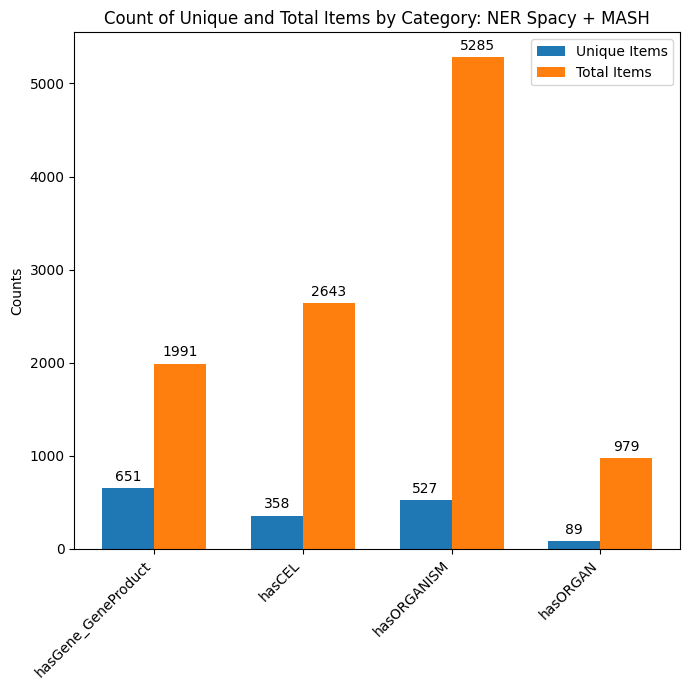

In [21]:
unique_gene_products = set()
unique_cels = set()
unique_organisms = set()
unique_organs = set()


for item in data_NER_aufruf:
    unique_gene_products.update(item.get('hasGene_GeneProduct', set()))
    unique_cels.update(item.get('hasCEL', set()))
    unique_organisms.update(item.get('hasORGANISM', set()))
    unique_organs.update(item.get('hasORGAN', set()))


total_gene_products = sum(len(item.get('hasGene_GeneProduct', set())) for item in data_NER_aufruf)
total_cels = sum(len(item.get('hasCEL', set())) for item in data_NER_aufruf)
total_organisms = sum(len(item.get('hasORGANISM', set())) for item in data_NER_aufruf)
total_organs = sum(len(item.get('hasORGAN', set())) for item in data_NER_aufruf)


unique_counts_MESH = {
    'hasGene_GeneProduct': len(unique_gene_products),
    'hasCEL': len(unique_cels),
    'hasORGANISM': len(unique_organisms),
    'hasORGAN': len(unique_organs)
}

total_counts_MESH = {
    'hasGene_GeneProduct': total_gene_products,
    'hasCEL': total_cels,
    'hasORGANISM': total_organisms,
    'hasORGAN': total_organs
}

plot_category_counts(unique_counts, total_counts, title='Count of Unique and Total Items by Category: NER Spacy')
plot_category_counts(unique_counts_MESH, total_counts_MESH, title='Count of Unique and Total Items by Category: NER Spacy + MASH')


#### Frequency of entities after MASH enrichment

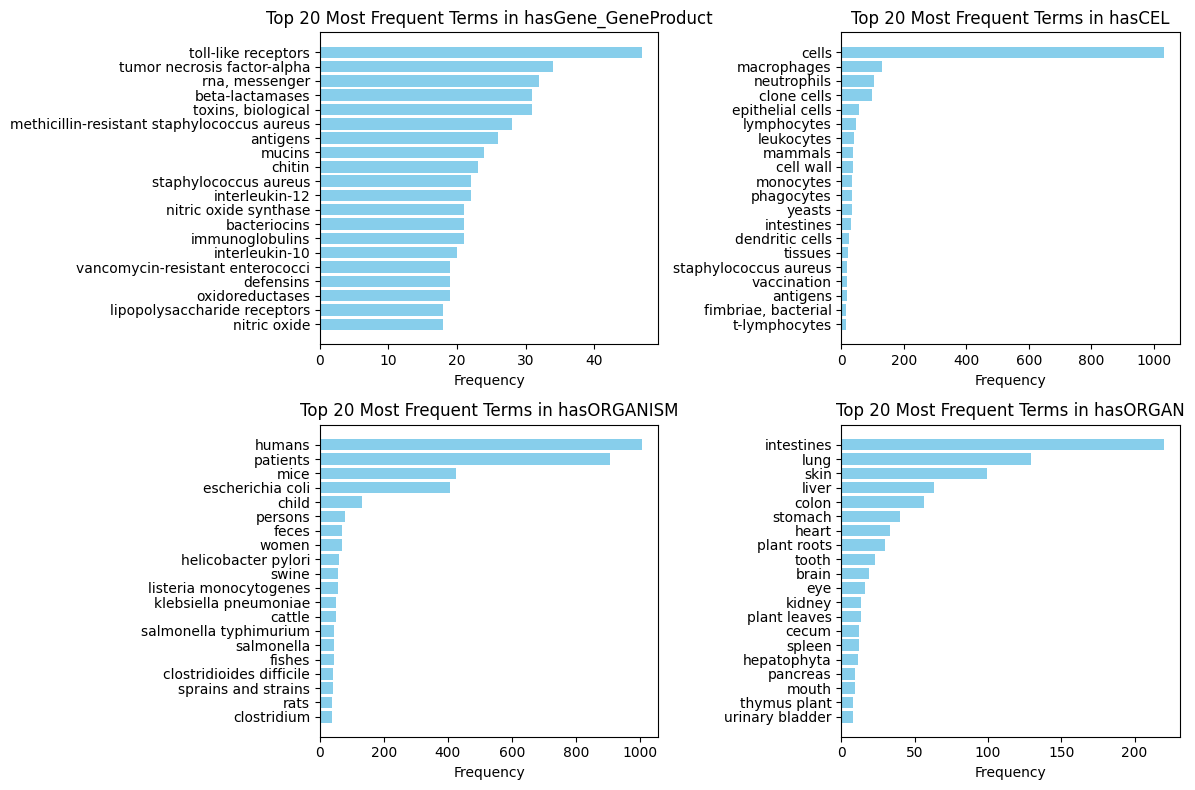

In [13]:
import matplotlib.pyplot as plt
from collections import Counter

categories = ['hasGene_GeneProduct', 'hasCEL', 'hasORGANISM', 'hasORGAN']
total_counts = [total_gene_products, total_cels, total_organisms, total_organs]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for category, total_count, ax in zip(categories, total_counts, axs.flatten()):
    all_terms = [term for sublist in (item.get(category, []) for item in data_NER_aufruf) for term in sublist]
    term_counts = Counter(all_terms)
    top_terms = [term[0] for term in term_counts.most_common(20)]
    top_frequencies = [term_counts[term] for term in top_terms]

    ax.barh(top_terms, top_frequencies, color='skyblue')
    ax.set_title(f'Top 20 Most Frequent Terms in {category}')
    ax.set_xlabel('Frequency')

    ax.invert_yaxis()


plt.tight_layout()
plt.show()
